In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import constants
from scipy.interpolate import make_interp_spline, BSpline
from matplotlib.patches import FancyArrowPatch
from matplotlib.path import Path
from matplotlib.lines import Line2D
import ipywidgets as widgets
from IPython.display import display
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from uncertainties import ufloat, unumpy
from scipy.odr import ODR, Model, Data, RealData
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as ticker
from sympy import symbols, Eq, solve
from scipy.integrate import quad
import matplotlib.gridspec as gridspec
from scipy.optimize import fsolve

## Versuchsteil 2

In [39]:
file_path = '/Users/danielmiksch/Downloads/C42_2.csv'
data_C42_2 = pd.read_csv(file_path, sep=',')

In [40]:
np.set_printoptions(suppress=True, precision=10)
data_2 = data_C42_2.to_numpy()

theta_2 = data_2[:,0]
U_2 = (data_2[:,1]) * 1000 #in mV
theta_2_rad = np.radians(theta_2)

val_lower = np.min(np.where(U_2 > 0))
val_upper = np.max(np.where(U_2 > 0))
U_2 = U_2[val_lower:val_upper+1]
theta_2_rad = theta_2_rad[val_lower:val_upper+1]
# print(np.where(U_2 > 0))
U_2

array([ 0.1,  4.5,  9.5, 18.6, 31.5, 40.5, 48.3, 57.5, 62.6, 62. , 54.5,
       44.4, 39.7, 36.1, 24.6, 16.4,  8.3,  2.4])

In [41]:
d_theta = np.radians(1)
d_theta_21 = np.full(len(theta_2), d_theta)
# d_deg = np.full(len(deg), d_theta)
d_U_21 = (U_2 * 0.00025 + 0.00005 * 10000)

d_theta_21 = d_theta_21[val_lower:val_upper+1]
d_U_21
# d_data_sym = (data_sym * 0.008 + 8)

array([0.500025, 0.501125, 0.502375, 0.50465 , 0.507875, 0.510125,
       0.512075, 0.514375, 0.51565 , 0.5155  , 0.513625, 0.5111  ,
       0.509925, 0.509025, 0.50615 , 0.5041  , 0.502075, 0.5006  ])

### Gauss Fit / Halbwertswinkel

In [42]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

In [43]:
def gaussian_odr(p, x):
    A, mu, sigma = p
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

In [44]:
model = Model(gaussian_odr)
data = RealData(theta_2_rad, U_2, sx=d_theta_21, sy=d_U_21)
odr = ODR(data, model, beta0=[62.5, -0.01, 0.08])

output = odr.run()
output.pprint()


Beta: [62.5074514741 -0.0087701423  0.0820933775]
Beta Std Error: [0.5637223582 0.0035443042 0.0024638871]
Beta Covariance: [[ 0.4687699257  0.0002246421 -0.000296714 ]
 [ 0.0002246421  0.0000185307 -0.0000004482]
 [-0.000296714  -0.0000004482  0.0000089551]]
Residual Variance: 0.6779080305415918
Inverse Condition #: 0.02762340644469362
Reason(s) for Halting:
  Sum of squares convergence


In [45]:
y_predicted = gaussian_odr(output.beta, theta_2_rad)
residuals = U_2 - y_predicted

chi2 = sum((residuals / d_U_21) ** 2)
n = len(U_2) - len(output.beta)

red_Chi2 = chi2 / n
red_Chi2

80.2011995302093

In [46]:
popt_gauss, pcov_gauss = curve_fit(gaussian, theta_2_rad, U_2, sigma=d_U_21, absolute_sigma=True, p0=[60, -1, 1])
A, mu, sigma = popt_gauss
d_A, d_mu, d_sigma = np.sqrt(np.diag(pcov_gauss))
pcov_gauss

array([[ 0.048843433 , -0.000003206 , -0.0000576387],
       [-0.000003206 ,  0.0000002082, -0.0000000057],
       [-0.0000576387, -0.0000000057,  0.0000002328]])

In [47]:
y_predicted = gaussian(theta_2_rad, A, mu, sigma)
residuals = U_2 - y_predicted

chi2 = sum((residuals / d_U_21) ** 2)
n = len(U_2) - len(popt_gauss)

red_Chi2 = chi2 / n
red_Chi2

42.011432036307184

In [48]:
def gaussian_helper(x):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) - A/2

x_1, x_2 = fsolve(gaussian_helper, [-0.09, 0.122])
y_1, y_2 = [gaussian(x_1, A, mu, sigma), gaussian(x_2, A, mu, sigma)]
FWHM = np.degrees(np.abs(x_1) + np.abs(x_2))
d_sigma

0.00048253564227403574

In [49]:
sig_with_err = ufloat(sigma, d_sigma)
fwhm = 2*np.sqrt(2*np.log(2))*sig_with_err
fwhm = np.degrees(unumpy.nominal_values(fwhm))
fwhm_err = np.degrees(unumpy.std_devs(fwhm))
fwhm = ufloat(fwhm, fwhm_err)
print(FWHM)
print(fwhm)


11.557371151298561
11.557371151508468+/-0


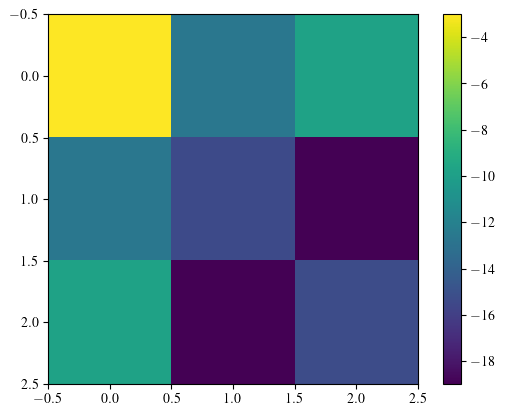

In [50]:
plt.imshow(np.log(np.abs(pcov_gauss)))
plt.colorbar()
plt.show()

In [51]:
x = np.linspace(-np.pi, np.pi, 2000)

/var/folders/_s/ymfv76ms5rs0hd9l43mh92_80000gn/T/ipykernel_92321/3591493301.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


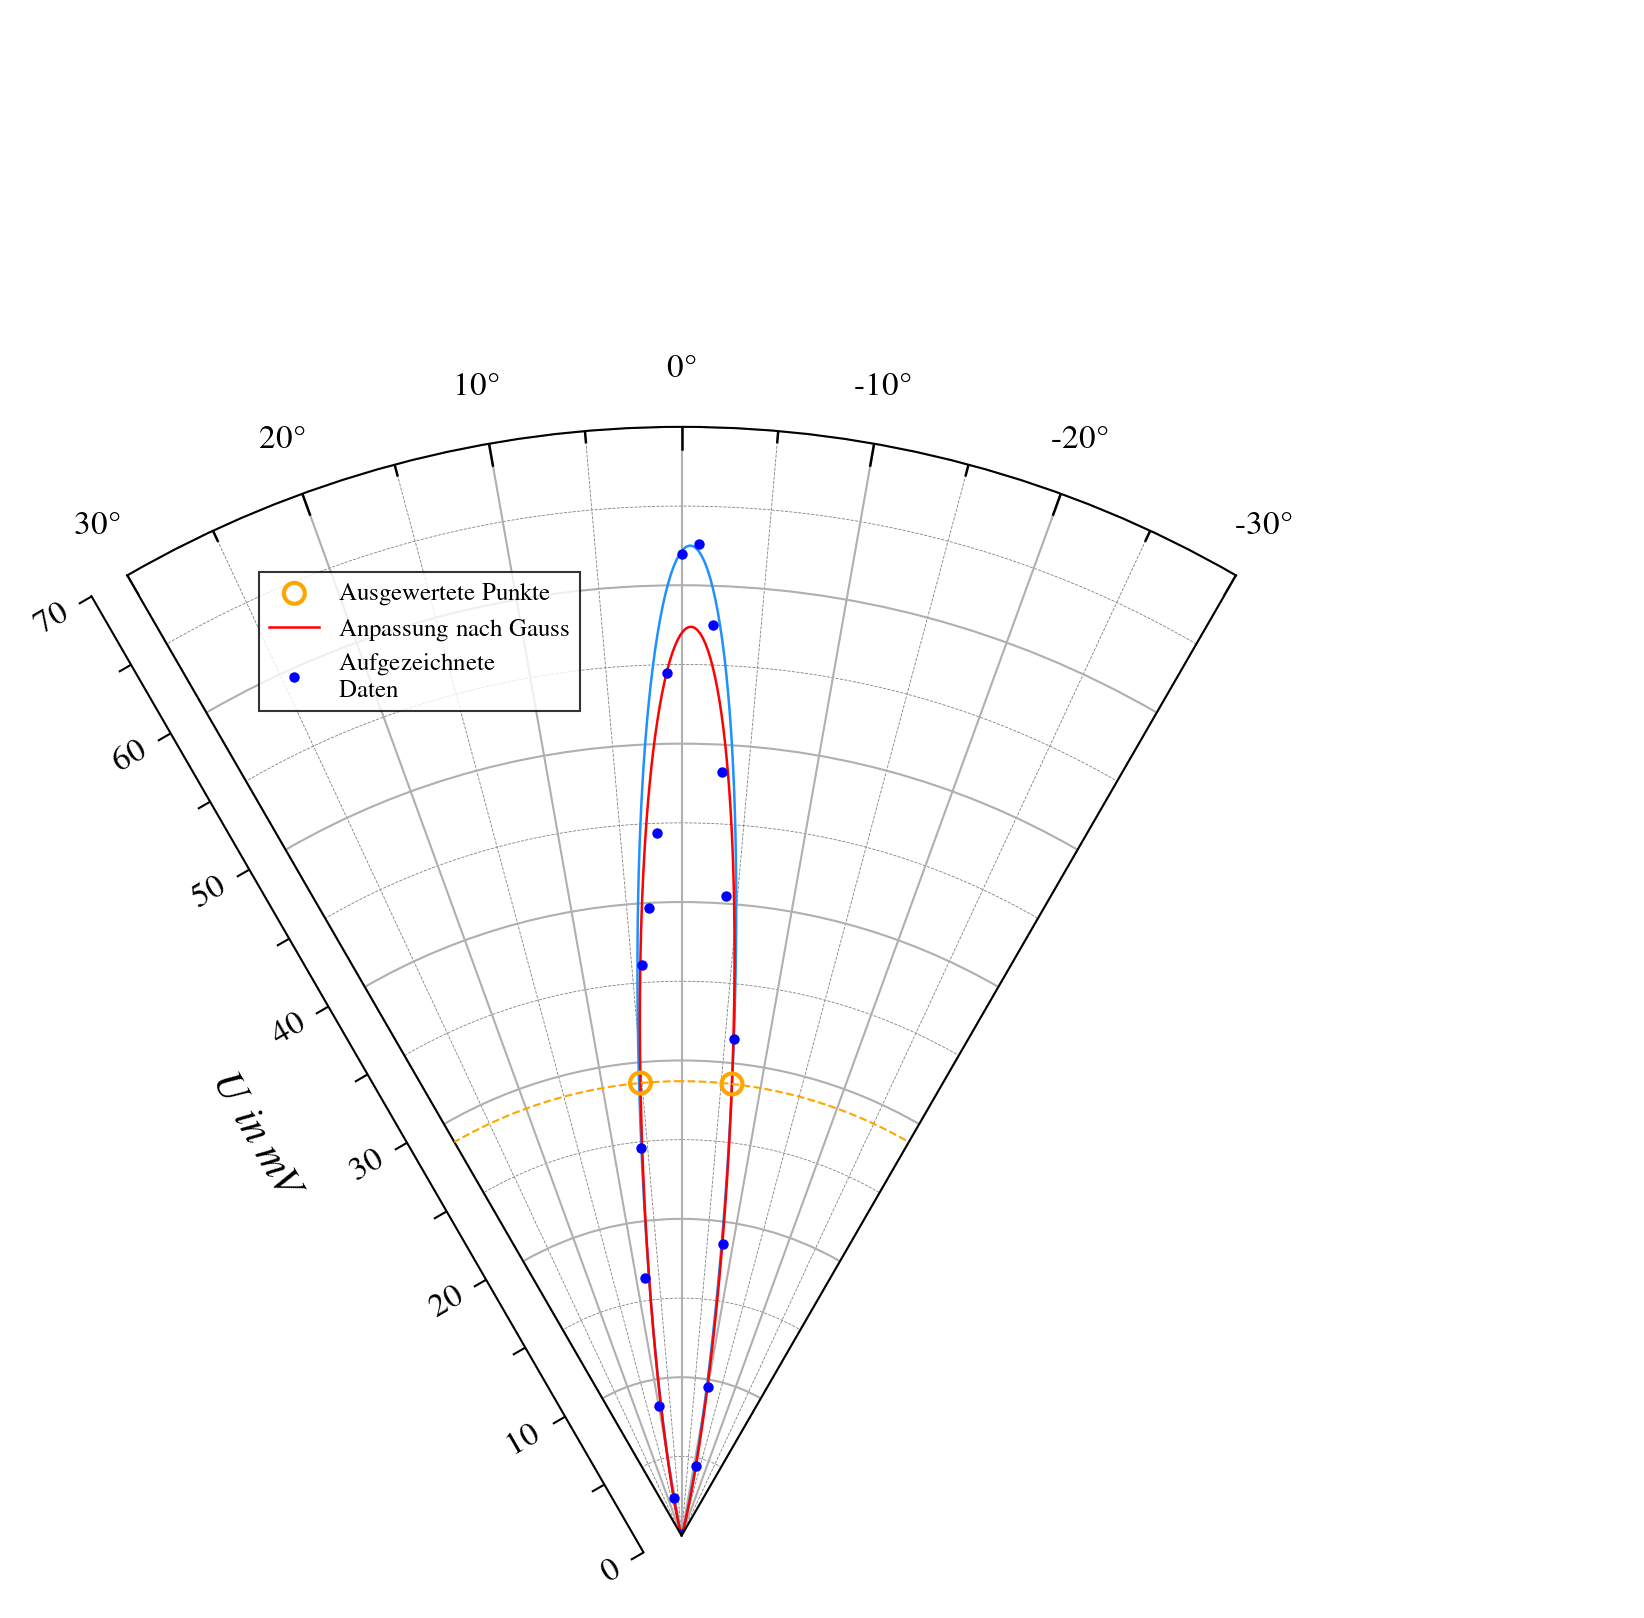

In [52]:
plt1 = fig, ax = plt.subplots(dpi=300, subplot_kw={'projection': 'polar'})

plt.rcParams["font.family"] = "times"
plt.rcParams["text.usetex"] = True

theta = np.linspace(0, 2*np.pi, 1000)

#Plot line at A/2
ax.plot(theta, [A/2] * len(theta),
        linewidth=.5,
        color='orange',
        linestyle='--',
        zorder=4)
ax.scatter([x_1,x_2], [y_1, y_2], marker='.', 
           s=100,
           edgecolors='orange',
           facecolors='none',
           label='Ausgewertete Punkte',
           zorder=3)
ax.plot(x, gaussian_odr(output.beta, x), linewidth=.6, c='dodgerblue')
ax.plot(x, gaussian(x, A, mu, sigma),
        linewidth=.6,
        c='red',
        label='Anpassung nach Gauss',
        zorder=2)
ax.errorbar(theta_2_rad, U_2,
            xerr=d_theta_21, yerr=d_U_21,
            capsize=0,
            ecolor='black',
            elinewidth=0,
            capthick=0,
            markersize=5, fmt=".",
            markeredgecolor='none', c="blue",
            label='Aufgezeichnete\n Daten',
            zorder=2)

ax.set_rlim(0, 70)
labels = ['' for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.set_rlabel_position(3)

alpha = 30

ax.set_theta_zero_location('N')
ax.set_thetamin(-alpha)
ax.set_thetamax(alpha)

ax.set_xticks(np.deg2rad(np.arange(-30, 31, 10)))
long_tick = [ax.get_rmax(), ax.get_rmax()*0.98]
short_tick = [ax.get_rmax(), ax.get_rmax()*0.99]  
for i, t in enumerate(np.deg2rad(np.arange(0, 360, 5))):
    if i % 2 == 0:  # Prüft, ob der Index gerade ist
        ax.plot([t, t], long_tick, lw=0.6, color="k")
    else:
        ax.plot([t, t], short_tick, lw=0.6, color="k")

ax.grid(linewidth=0.5, zorder=1)

# Minor grid lines angle
r_max = ax.get_rmax()
for angle in np.deg2rad(np.arange(0, 360, 5)):
    ax.plot([angle, angle], [0, r_max], color='gray', linestyle='--', linewidth=0.2, zorder=1)  # Setze die gewünschte Linienfarbe und -stärke

# Minor grid lines radius
for r in np.arange(0, 70, 5):
    theta = np.linspace(0, 2*np.pi, 1000)
    ax.plot(theta, [r] * len(theta), linewidth=0.2, color='gray', linestyle='--', zorder=1)

# Size Angle Labels
for label in ax.get_xticklabels():
    label.set_fontsize(8)

X_OFFSET = 0.04
def add_scale(ax):
    
    angle = 30
    alpha = 30
    
    rect = ax.get_position(original=False)
    rot2 = Affine2D().rotate_deg(angle)
    
    major_ticks = [(0, r"$0$"),
                   (5, r""),
                   (10, r"$10$"),
                   (15, r""),
                   (20, r"$20$"),
                   (25, r""),
                   (30, r"$30$"),
                   (35, r""),
                    (40, r"$40$"),
                    (45, r""),
                   (50, r"$50$"),
                   (55, r""),
                   (60, r"$60$"),
                   (65, r""),
                   (70, r"$70$")]
    grid_locator1 = FixedLocator([v for v, s in major_ticks])
    tick_formatter1 = DictFormatter(dict(major_ticks))

    grid_helper = floating_axes.GridHelperCurveLinear(
        rot2, extremes=(0, 70, 0, 70),
        grid_locator1=None,
        grid_locator2=grid_locator1,
        tick_formatter2=tick_formatter1,
        tick_formatter1=None)
    
    ax1 = floating_axes.FloatingSubplot(fig, 111, grid_helper=grid_helper)
    
    x = (rect.height/(2*np.sin(np.radians(alpha))) + 0.012)
    
    rect_new = (rect.xmin-0.16,
                rect.ymin + ((rect.height - (rect.height/(2*np.sin(np.radians(alpha)))))/2) - 0.006 - 0.016, # x, y
            (x / np.cos(np.radians(alpha))) + (np.sin(np.radians(alpha)) * (x - x * np.tan(np.radians(alpha)))),
                (x / np.cos(np.radians(alpha))) + (np.sin(np.radians(alpha)) * (x - x * np.tan(np.radians(alpha)))))# width, height    

    ax1.set_position(rect_new)
    scale_ax = fig.add_subplot(ax1)

    for loc in ['right', 'top', 'bottom']:
        scale_ax.axis[loc].set_visible(False)
        scale_ax.axis[loc].line.set_linewidth(.2)
    scale_ax.tick_params(bottom=False, labelbottom=False, width=.5, labelsize=50)
    scale_ax.patch.set_visible(False)
    scale_ax.axis['left'].label.set_text(r"$U\;in\;mV$")
    scale_ax.axis['left'].label.set_size(10)
    scale_ax.axis['left'].major_ticklabels.set_fontsize(8)
    scale_ax.axis['left'].label.set_rotation(0)# hide white background
    scale_ax.axis['left'].major_ticks.set_tick_out(True) # hide white background
    scale_ax.axis['left'].label.set_pad(20)
    scale_ax.axis['left'].line.set_linewidth(.5)
    scale_ax.axis['left'].toggle(ticklabels=True, label=True)
add_scale(ax)

for spine in ax.spines.values():
    spine.set_linewidth(0.5)
    
legend = ax.legend(loc="upper right", bbox_to_anchor=(0.42, 0.88), fancybox=False, edgecolor='black', fontsize=6)
legend.set_zorder(10)
legend.get_frame().set_linewidth(0.5)

plt.show()

# fig.savefig("/Users/danielmiksch/Downloads/plot_winkel.png")

## Versuchsteil 3

In [53]:
file_path = '/Users/danielmiksch/Downloads/C42_3.csv'
data_C42_3 = pd.read_csv(file_path, sep=',')
#print(data_m9)

In [54]:
np.set_printoptions(suppress=True, precision=10)
data_np3 = data_C42_3.to_numpy()
#removing datapoint
diff = np.diff(data_np3[:,1])
indc = np.where((diff[:-1] < 0) & (diff[1:] > 0))[0] + 1

position_lense = 1.2

x_lense = np.delete(data_np3[:,0], indc)
y_lense = np.delete(data_np3[:,1], indc)

plot_lense_x = position_lense - x_lense
plot_lense_y = y_lense

x_lense = position_lense - x_lense[6:-1]
y_lense = y_lense[6:-1]
d_y = (y_lense * 0.00025 + 0.00005 * 10)
d_x = np.full(len(x_lense), np.sqrt(2) * 0.002)
# data_np3[:,0][3:]

In [55]:
def lorentzian(x, A, mu, gamma):
    return A * (gamma**2 / ((x - mu)**2 + gamma**2))

def lorentzian_odr(p, x):
    A, mu, gamma = p
    return A * (gamma**2 / ((x - mu)**2 + gamma**2))

def quadratic(p, x):
    a, b, c = p#p0=[0.7, 0.5, 0.1]
    return a*x**4+b*x**2+c

def red_chi2(model, x, y, sy, popt):  
    y_predicted = model
    residuals = y - y_predicted
    chi2 = sum((residuals / sy) ** 2)
    n = len(y) - len(popt)
    fig, ax = plt.subplots()
    plt.scatter(x, residuals)
    ax.axhline(0, color='grey', linestyle='-', linewidth=0.5, zorder=1)
    print('Red. Chi2 = {}'.format(chi2/n))

In [56]:
popt_lense, pcov_lense = curve_fit(lorentzian, x_lense, y_lense, sigma=d_y, absolute_sigma=True)
a, b, c = popt_lense
np.sqrt(np.diag(pcov_lense))

array([0.0002569109, 0.0001635033, 0.0004500059])

Red. Chi2 = 202.32217644985369


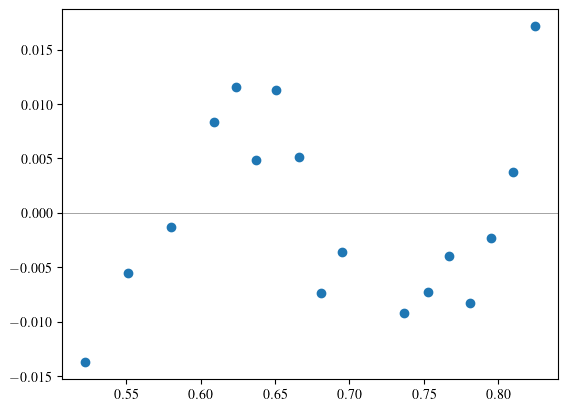

In [57]:
red_chi2(lorentzian(x_lense, a, b, c), x_lense, y_lense, d_y, popt_lense)

In [58]:
model = Model(lorentzian_odr)
data = RealData(x_lense, y_lense, sx=d_x, sy=d_y)
odr = ODR(data, model, beta0=[0.7, 0.7, 0.1])

output = odr.run()
output.pprint()

Beta: [0.6999808702 0.7294387796 0.2690701441]
Beta Std Error: [0.0021019803 0.0023351217 0.0070931806]
Beta Covariance: [[ 0.0000005921 -0.0000002417 -0.0000011834]
 [-0.0000002417  0.0000007307  0.0000012192]
 [-0.0000011834  0.0000012192  0.0000067426]]
Residual Variance: 7.4619725554946115
Inverse Condition #: 0.22676211421168666
Reason(s) for Halting:
  Sum of squares convergence


Red. Chi2 = 249.33530237404122


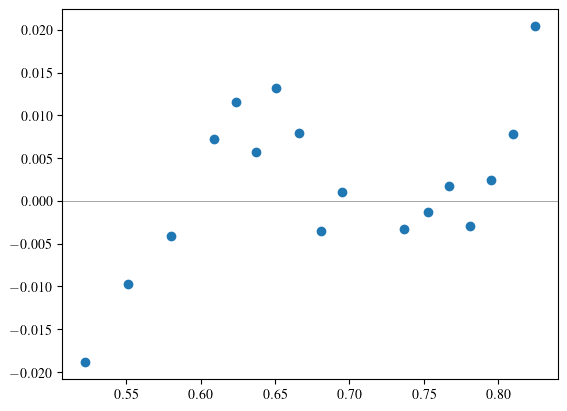

In [59]:
red_chi2(lorentzian_odr(output.beta, x_lense), x_lense, y_lense, d_y, output.beta)

In [60]:
x = np.linspace(min(x_lense), max(x_lense), 1000)
y = lorentzian(x, a, b, c)

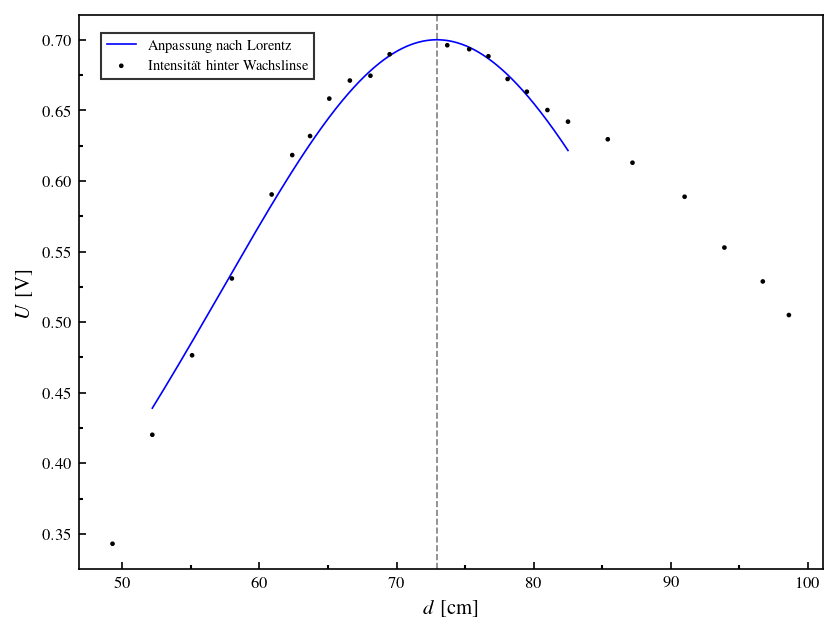

In [61]:
fig, ax = plt.subplots(dpi=150)

plt.plot(x * 100, lorentzian_odr(output.beta, x), c='blue', linewidth=.8, label='Anpassung nach Lorentz', zorder=2)
plt.scatter(plot_lense_x * 100, plot_lense_y, marker='.', s=20, edgecolors='none', color='black', label='Intensität hinter Wachslinse', zorder=2)
# plt.plot(x * 100, y, c='red', linewidth=.8, label='Anpassung nach Lorentz', zorder=2)

ax.set_ylabel('$U$ [V]')
ax.set_xlabel('$d$ [cm]')
# ax.set_xlim(20, 75)
# ax.set_ylim(0.3, 0.75)

ax.axvline(output.beta[1] * 100, color='grey', linestyle='--', linewidth=0.8, zorder=1)

ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
plt.tick_params(which='minor',direction='in', labelsize=8, width=1, length=2)
plt.tick_params(which='major',direction='in', labelsize=8)

plt.legend(loc="upper left", bbox_to_anchor=(0.02, 0.98), fancybox=False, edgecolor='black', fontsize=7)
plt.show()

In [62]:
g = ufloat(0.8, np.sqrt(2)*0.002)
d = ufloat(output.beta[1], np.sqrt(2)*0.002)
f = (g*d)/(g+d)
f

0.38154585295013765+/-0.0010063674096813988

## Versuchsteil 4

In [63]:
file_path = '/Users/danielmiksch/Downloads/C42_4.csv'
data_C42_4 = pd.read_csv(file_path, sep=',')

In [64]:
np.set_printoptions(suppress=True, precision=10)
data_np4 = data_C42_4.to_numpy()
data_np4

array([[ 0.365,  0.   ],
       [ 0.508, 10.   ],
       [ 0.653, 20.   ],
       [ 0.798, 30.   ]])

In [65]:
np.diff(data_np4[:,0])

array([0.143, 0.145, 0.145])

## Versuchsteil 5

In [66]:
file_path = '/Users/danielmiksch/Downloads/C42_5.csv'
data_C42_5 = pd.read_csv(file_path, sep=',')

In [67]:
np.set_printoptions(suppress=True, precision=10)
data_np5 = data_C42_5.to_numpy()
data_np5

array([[ 0.004,  0.   ],
       [ 0.165, 10.   ],
       [ 0.322, 20.   ]])

In [68]:
np.diff(data_np5[:,0])

array([0.161, 0.157])

## Versuchsteil 6

In [69]:
file_path = '/Users/danielmiksch/Downloads/C42_6.csv'
data_C42_6 = pd.read_csv(file_path, sep=',')

In [70]:
np.set_printoptions(suppress=True, precision=10)
data_np6 = data_C42_6.to_numpy()
x_block = data_np6[:,0]
y_block = data_np6[:,1]

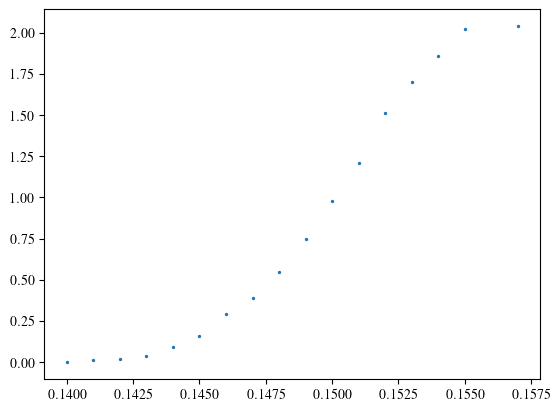

In [71]:
plt.scatter(x_block, y_block, s=2)

## Versuchsteil 8

In [72]:
file_path = '/Users/danielmiksch/Downloads/C42_8.csv'
data_C42_8 = pd.read_csv(file_path, sep=',')

In [73]:
np.set_printoptions(suppress=True, precision=10)
data_np8 = data_C42_8.to_numpy()
x_crystal = data_np8[:,0]
y_crystal = data_np8[:,1]

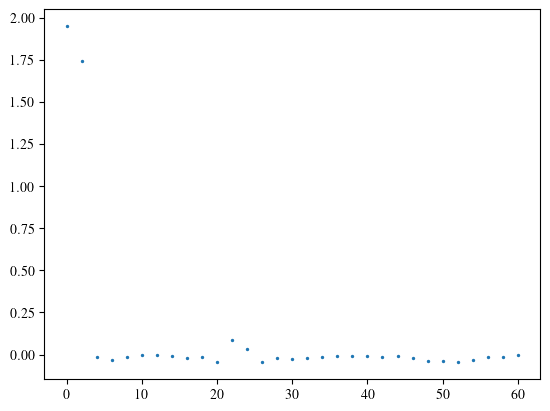

In [74]:
plt.scatter(x_crystal, y_crystal, s=2)